<a href="https://colab.research.google.com/github/hemanthkumar17/DL4VL/blob/main/Image%20Classification%20and%20Convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## **Image Classification and Convolutional Neural Networks (CNNs)** [10pts]

In this class we will be relying on Python as a programming language and pytorch as a primary framework of choice. For an introduction to Python for image manipulation you can do a refresher by first completing this notebook: [[Python, Numpy and Image Processing](https://colab.research.google.com/drive/1fI8_ga1ZG1vGPpJUwBMdxnPX6ntrUgrh)]. For a gentle introduction to Pytorch you can complete first this notebook: [[Python, Pytorch and Plotting](https://colab.research.google.com/drive/1UQM4Lzs1sKbmZ7g3D1f98ATTSZM5EyGW?usp=sharing)].

### **0. Preliminaries**
In this section, we will review some basic Pytorch to demonstrate its capabilities for gradeint-based optimization. Consider for instance the following function:

$$ y = 4x + 3z^2$$

Your task is to find the gradient $\nabla y = \left(\frac{\partial y}{\partial x}, \frac{\partial y}{\partial z}\right)$ for when $x = 2$ and $z = 3$. How do we do this? There are three ways we can do this. 

#### **0.1 Analytical derivation**
First, we can compute the analytical formula for this function as follows:

$$\frac{\partial y}{\partial x} = 4 \quad\text{ and }\quad \frac{\partial y}{\partial z} = 6z$$

We can easily see that the gradient at $(x,z) = (2, 3)$ is $\nabla y = (4, 18) $. No need to write any code.

#### **0.2 Numerical approximation**
The other method we can apply is based on approximation. Let's have $y = f(x,z)$, then the definitions of partial derivatives can be expressed as follows:

$$ \frac{\partial}{\partial x} f(x,z) = \lim_{h_x \to 0} \frac{f(x + h_x, z) - f(x, z)}{h_x}$$

$$ \frac{\partial}{\partial z} f(x,z) = \lim_{h_z \to 0} \frac{f(x, z + h_z) - f(x, z)}{h_z}$$

We can quickly compute this below using some basic Python functions.

In [1]:
def f(x,z):
  return 4 * x + 3 * z * z

def grad_x(f, x, z, h = 0.0001):
  return (f(x + h, z) - f(x, z)) / h

def grad_z(f, x, z, h = 0.0001):
  return (f(x, z + h) - f(x, z)) / h

print(grad_x(f, 2, 3), grad_z(f, 2, 3))

3.9999999999906777 18.000300000053926


As we can see, the approximation is fairly correct, returning almost the same result as the analytical derivation.

#### **0.3 Pytorch autograd**

Writing your own derivations is fine but pytorch already implements the gradient based computation for all basic operations you might need and it keeps track of the operations that are being applied when using the Pytorch tensor datatype. Anytime you need to compute gradients you can call the backward() function on a tensor and it will apply the chain rule of calculus to compute the derivatives for all the history of operations applied to said tensor.

In [2]:
import torch 

# This function assumes, x, z are pytorch tensors but it looks the
# same as the earlier function. We could also restrict the data types in python3.
def f(x: torch.tensor, z: torch.tensor):
  return 4 * x + 3 * z * z

x = torch.tensor(2.0, requires_grad = True)
z = torch.tensor(3.0, requires_grad = True)

# Compute the value of y.
y = f(x,z)

# Compute the gradients for all variables.
y.backward()

# Print the gradients
print(x.grad, z.grad)

tensor(4.) tensor(18.)


We can see that we can obtain the same result, except the Pytorch function is much more general. For starters, $x$ and $z$ could be vectors in this implementation without changing anything. There is no need to compute the analytical derivation and there is no need to have a separate function for each partial derivative. Another thing to keep in mind, usually we will be optimizing variables that we name $W = [w_1, w_2, ...]$ and we will use $y$ and $x$ to denote constants since those we use to represent the training data, so let us not get confused by this. You will be able to see this more clearly in the first part of the assignment section.

### **1. The SUN Dataset** [2pts]
In 2009, a group of researchers developed SUN397, a database of images that was supposed to cover as many categories of images of "scenes" as possible (see more information [here](https://vision.princeton.edu/projects/2010/SUN/)). The dataset has at least 100 images for each of 397 categories. The entire dataset fits in a 39GB tar file.  

#### **1.1 Downloading the Data**
For this assignment, we created a subset of this dataset containing only 20 categories, and we pre-resized the images so that their longest size is 256 pixels -- and we also restricted each category to have exactly 50 images. 

In [3]:
# This command downloads the files with the prepackaged contents.
!wget -nc http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz
!wget -nc http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-val.tar.gz
!tar xf SUN20-train-sm.tar.gz
!tar xf SUN20-val.tar.gz

--2023-01-22 20:35:56--  http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:80... connected.
HTTP request sent, awaiting response... 302 Found : Moved Temporarily
Location: https://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz [following]
--2023-01-22 20:35:57--  https://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39744791 (38M) [application/x-gzip]
Saving to: ‘SUN20-train-sm.tar.gz’

SUN20-train-sm.tar. 100%[===================>]  37.90M  1.01MB/s    in 38s     

2023-01-22 20:36:35 (1016 KB/s) - ‘SUN20-train-sm.tar.gz’ saved [39744791/39744791]

--2023-01-22 20:36:35--  http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-val.tar.gz
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecti

#### **1.2 Creating a Custom Data Loader**
In Pytorch a dataset class must inherit from `torch.utils.data.Dataset` and 
it must override two methods: `__getitem__` and `__len__`. These methods must return a sample and the number of samples respectively.

In [4]:
import os, json, pickle, random
import torch.utils.data
from PIL import Image

# Simple implementation of a custom data loading class for our SUN20 dataset.
class SUN20(torch.utils.data.Dataset):

  # Initialize the class e.g. load files, preprocess, etc.
  def __init__(self, split = 'train', transform = None):
    
    # These are the 20 categories selected.
    self.categories = open('SUN20/' + split + '/ClassName.txt').read().split('\n')[:-1]
    self.categories = sorted(self.categories)
    self.category2index = {category: idx for (idx, category) in enumerate(self.categories)}
    self.transform = transform

    # Compile a list of images and corresponding labels.
    self.imagepaths = []
    self.labels = []
    for category in self.categories:
      category_directory = 'SUN20/' + split + category
      category_imagenames = os.listdir(category_directory)
      self.imagepaths += [os.path.join(category_directory, imagename) 
                          for imagename in category_imagenames]
      self.labels += [self.category2index[category]] * len(category_imagenames)
    # Sort imagepaths alphabetically and labels accordingly.
    sorted_pairs = sorted(zip(self.imagepaths, self.labels), key = lambda x: x[0])
    self.imagepaths, self.labels = zip(*sorted_pairs)

        
  # Return a sample (x, y) as a tuple e.g. (image, label)
  def __getitem__(self, index):
    image = Image.open(self.imagepaths[index]).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image, self.labels[index]
  
  # Return the total number of samples.
  def __len__(self):
    return len(self.imagepaths)


#### **1.3 Using the Custom Data Loader**

Here we show how to use the SUN20 dataset using our dataloader class, and we show how to explore images on this dataset. Before starting any project in vision+language it is always useful to write code to explore the dataset and visualize the data.

This dataset has 1000 training images
Image 0 is a /a/arch
Image size is 379x250


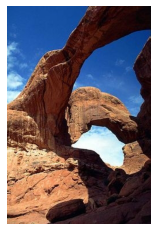

In [5]:
import matplotlib
import matplotlib.pyplot as plt

trainset = SUN20(split = 'train')
image_index = 0  # Feel free to change this.

# 1. Datasets need to implement the __len__ method for this to work.
print('This dataset has {0} training images'.format(len(trainset)))

# 2. Datasets need to implement the  __getitem__ method for this to work.
img, label = trainset[image_index]  # Returns image and label.

print('Image {0} is a {1}'.format(image_index, trainset.categories[label]))
print('Image size is {0}x{1}'.format(img.height, img.width))

# Show the image.
plt.figure();plt.imshow(img);
plt.grid(False); plt.axis('off'); plt.show()

#### **1.4 Exploring Images in the SUN20 Dataset** **[2pts]**
***Dataset Statistics:*** The objective of this section is for you to demonstrate that you know how to use the dataloader and know how to do some basic image manipulation using Python/Pytorch. Write code below to print the number of images shot in portrait mode (height larger than width) in the dataset for each category and sorted in decreasing order by this number. I'm including the numbers that I got. **[1pt]**

**Challenge**: Try to do it using the minimal amount of for loops possible, in the shortest running time possible and with the least number of lines of code that you can, also make your code legible and easy to understand. Record your personal best on this spreadsheet: [[leaderboard](https://docs.google.com/spreadsheets/d/1Bb2d8nU3WzwXYgzPIL70SfHjqlPBP0RsB5Ws6a0xfPI/edit?usp=sharing)]

In [6]:
# Your code goes here.
import collections
train, val = SUN20(split = "train"), SUN20(split = "val")
# train_c, val_c = collections.Counter(train.categories), collections.Counter(val.categories)
# print(collections.Counter(val.labels))
# print(train.labels)
train_freq = {}
for i in range(len(train)):
    img, label = train[i]
    train_freq[train.categories[label]] = train_freq[train.categories[label]] + 1 if train.categories[label] in train_freq else 1


**Note:** This is just a warm up exercise -- however an important thing to do before starting any new project. Exploring the dataset. Clearly this dataset is not ideal as some categories have a lot more images for training than others. However the validation set has an equal number of images. This is something we must take into account.

***Visualizing:*** The objective of this section is for you to visualize some of the images in the training dataset and get a sense of how challenging is the required task. Please show a handful of images arranged in a 4x12 grid for a given category so they can be shown as a single image as in the example below for `skyscraper`. Include in your assignment the output for the category `marsh`. Note: You probably need to crop and resize the images in order to stitch them together.  **[1pt]**

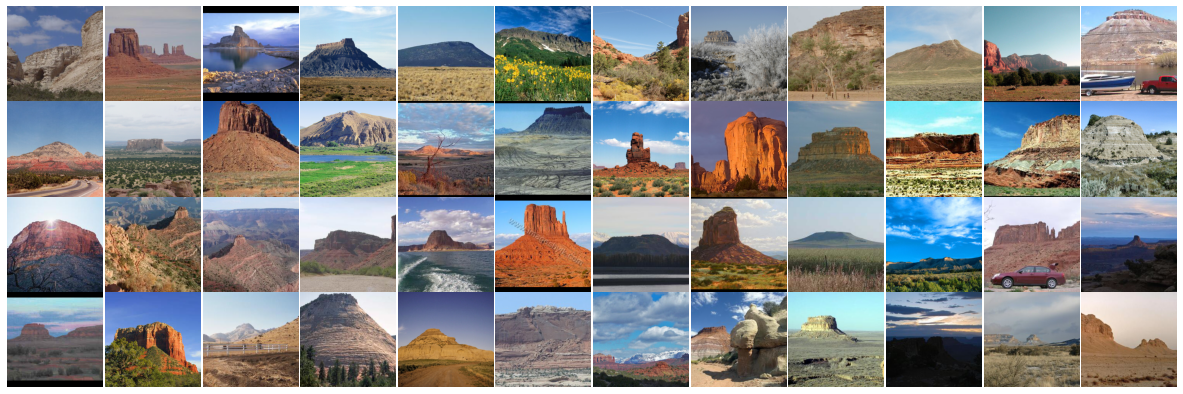

In [7]:
# Your code goes here.
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T

train = SUN20(split = "train")

cat = "butte"

loc = train.categories.index(f"/{cat[0]}/{cat}")
fig, ax = plt.subplots(4, 12, figsize=(21, 7))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(4):
    for j in range(12):
        img, label = train[50*loc + i*12+j]
        img = T.CenterCrop(size=250)(img)
        ax[i][j].imshow(img) 
        ax[i][j].axis("off")
        plt.imshow(img)
# plt.tight_layout()

**Note:** Hopefully after visualzing the category `butte` you can visualize what this word really means.

### **2. Linear Classifiers**
In this section we will explore how to define and train linear classifiers for classifying images into one of the 20 categories of the SUN20 dataset we just defined in the earlier section.

#### **2.1 Defining a Linear Text Classifier**
Now we can build a binary linear classifier and train it using SGD. We will rely on the Pytorch library for this purpose but we could use any. We don't need to compute gradients analytically since Pytorch keeps track of operations. In pytorch model classes have to inherit from `torch.nn.Module` and the function that takes inputs and produces predicted values, has to be implemented in their `forward` function. 

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Let's define a linear classifier (One layer neural network).
# Pytorch supports batches so this model already can receive a set of inputs
# and not just one vector at a time. e.g. inputs of size batch_size x input_size.
class LinearClassifier(nn.Module): 
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        # The classifier will be binary either positive or negative review.
        # So we only need one output variable in the linear layer.
        self.linear = nn.Linear(input_size, num_classes) 

    # Apply the linear operation and the softmax operation.
    def forward(self, encoded_input):
        return self.linear(encoded_input)

# Create an instance of this linear classifier.
model = LinearClassifier(32 * 32 * 3, len(trainset.categories))

# Create a dummy row vector filled with random values.
dummy_vector = torch.rand(1, 32 * 32 * 3)

# Compute some predictions using the model.
predictions = model(dummy_vector).softmax(dim = 1)

# Show predictions from this randomly initialized model.
for i in range(0, len(trainset.categories)):
  score = predictions[0, i].item()
  category = trainset.categories[i]
  print('P("{0}") = {1:.2f}'.format(category, score))

P("/a/arch") = 0.03
P("/b/bathroom") = 0.06
P("/b/butte") = 0.03
P("/d/dentists_office") = 0.04
P("/h/hot_spring") = 0.04
P("/j/jacuzzi/indoor") = 0.06
P("/l/laundromat") = 0.03
P("/l/lecture_room") = 0.06
P("/l/library/indoor") = 0.05
P("/l/lighthouse") = 0.07
P("/l/living_room") = 0.04
P("/m/mansion") = 0.03
P("/m/marsh") = 0.05
P("/m/mountain") = 0.04
P("/s/sauna") = 0.04
P("/s/shower") = 0.13
P("/s/skyscraper") = 0.05
P("/t/tower") = 0.07
P("/t/tree_house") = 0.05
P("/v/volcano") = 0.05


#### **2.2 Stochastic Gradient Descent (SGD) Loop**

Now we proceed to train the classifier we defined in the earlier section using (mini-batch) Stochastic Gradient Descent (SGD). Please review the code in the following section especially carefully. Every line of code is important. If you don't understand what something does please bring up in our discussion forums or during office hours.

In [9]:
!pip install livelossplot --quiet
from livelossplot import PlotLosses

# Defining as global the device to use (by default CPU).
device = torch.device("cuda")

def train_model(batch_size, 
                n_epochs, 
                learningRate, 
                model, 
                cost_function, 
                optimizer,
                scheduler,
                train_loader,
                val_loader):

  # Move the model and cost function to GPU (if needed).
  model = model.to(device)
  cost_function = cost_function.to(device)

  # Keep track of best accuracy so far.
  best_accuracy = 0 
  liveloss = PlotLosses()

  # Main for loop of SGD.
  for epoch in range(0, n_epochs):
    logs = {}

    # initialize control variables.
    correct = 0
    cumulative_loss = 0
    n_samples = 0

    # Set the model in training mode.
    model.train()

    # Sample a batch on each iteration.
    for (batch_id, (xb, yb)) in enumerate(train_loader):
      model.zero_grad()

      # Move (x,y) data to GPU (if so desired).
      xb = xb.to(device)
      yb = yb.to(device)

      # Compute predictions.
      predicted = model(xb)
      # print(xb.shape, yb.shape, predicted.shape)

      # Compute loss.
      loss = cost_function(predicted, yb)
      cumulative_loss += loss.item()

      # Count how many correct in batch.
      predicted_ = predicted.detach().softmax(dim = 1)
      max_vals, max_ids = predicted_.max(dim = 1)
      correct += (max_ids == yb).sum().cpu().item()
      n_samples += xb.size(0)

      # Compute gradients (autograd).
      loss.backward()

      # Run one basic training step of SGD.
      optimizer.step()
      # This does basically the following operation.
      # for param in model.parameters():
      #    param.data -= learningRate * param.grad.data

      # Keep track of loss and accuracy for the plot.
      n_batches = 1 + batch_id 
      logs['loss'] = cumulative_loss / n_batches
      logs['accuracy'] = correct / n_samples
    
    # initialize control variables.
    correct = 0
    cumulative_loss = 0
    n_samples = 0

    # Set the model in evaluation mode.
    model.eval()

    # No need to keep track of gradients for this part.
    with torch.no_grad():
      # Run the model on the validation set to keep track of accuracy there.
      for (batch_id, (xb, yb)) in enumerate(val_loader):

        # Move data to GPU if needed.
        xb = xb.to(device)
        yb = yb.to(device)
    
        # Compute predictions.
        predicted = model(xb)

        # Compute loss.
        loss = cost_function(predicted, yb)
        cumulative_loss += loss.item()

        # Count how many correct in batch.
        predicted_ = predicted.detach().softmax(dim = 1)
        max_vals, max_ids = predicted_.max(dim = 1)
        correct += (max_ids == yb).sum().cpu().item()
        n_samples += xb.size(0)

        # Keep track of loss and accuracy for the plot.
        n_batches = 1 + batch_id
        logs['val_loss'] = cumulative_loss / n_batches
        logs['val_accuracy'] = correct / n_samples

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth')

    # Update the plot with new logging information.
    liveloss.update(logs)
    liveloss.send()

    # What is this for? Please look it up.
    if scheduler != -1:
        scheduler.step()

  # Load the model parameters for the one that achieved the best val accuracy.
  # model.load_state_dict(torch.load('best_model_so_far.pth'))    

#### **2.3 Training of our Linear Classifier**

Running the code for training our LinearClassifier models and using data loaders for batch loading and assembly. Also carefully observe the usage of `torchvision.transforms`.

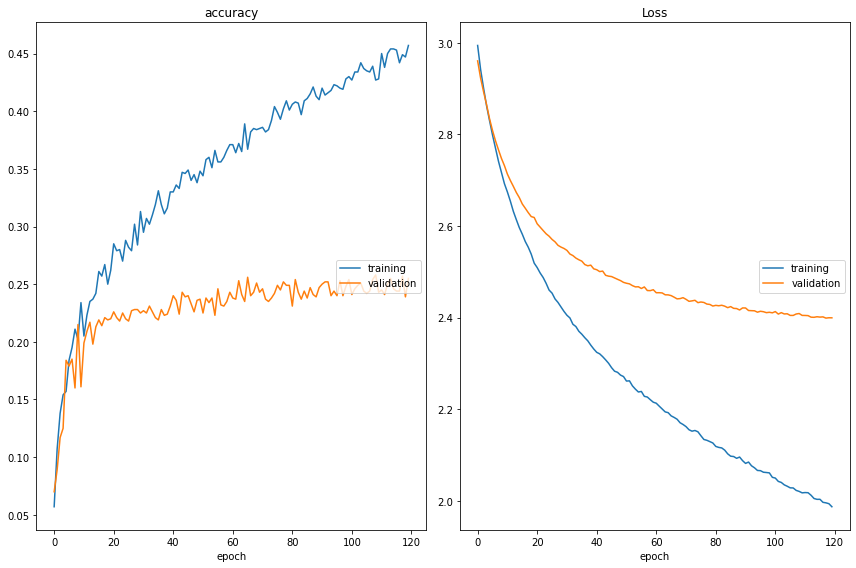

accuracy
	training         	 (min:    0.057, max:    0.457, cur:    0.457)
	validation       	 (min:    0.070, max:    0.258, cur:    0.255)
Loss
	training         	 (min:    1.987, max:    2.994, cur:    1.987)
	validation       	 (min:    2.399, max:    2.960, cur:    2.400)


In [10]:
import torch.optim 
import torchvision.transforms as transforms

batch_size = 16
n_epochs = 120
learningRate = 1e-3

# torch.nn.CrossEntropyLoss applies the softmax to the predictions by the model.
cost_function = torch.nn.CrossEntropyLoss()
model = LinearClassifier(32 * 32 * 3, len(trainset.categories))

# Basic SGD Optimizer.
optimizer = torch.optim.SGD(model.parameters(), lr = learningRate)

class Flatten(object):
  def __call__(self, input_tensor):
    return input_tensor.view(32 * 32 * 3)

transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                Flatten()])

trainset = SUN20(split = 'train', transform = transform)
valset = SUN20(split = 'val', transform = transform)

train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 2)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)

train_model(batch_size, n_epochs, learningRate, 
            model, cost_function, optimizer, -1, 
            train_loader, val_loader);

You can see this model is really learning the task, the accuracy keeps going up and loss on both the training data and even on the validation data keep going down. Despite this being the simplest humble linear classifier - it is somewhat working -- reaching an accuracy of about 26% and it looks like the training started to converge. What would random guessing do on this task?

### **3. Convolutional Neural Networks**

Our classifier in the previous section is not a very good one. In this section we will define a new classifier that uses instead a convolutional neural network. Here we provide a definition for such neural network. This network is designed to take images as input at a 48x48 resolution.

In [43]:
class ConvnetClassifier(torch.nn.Module):
    def __init__(self):
        super(ConvnetClassifier, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = (5, 5))
        self.conv2 = torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3, 3))
        self.linear1 = torch.nn.Linear(in_features = 128 * 10 * 10, out_features = 256)
        self.linear2 = torch.nn.Linear(in_features = 256, out_features = 20)

    def forward(self, x):
        # First conv layer + maxpool2d + relu.
        x = self.conv1(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        x = torch.nn.functional.relu(x)

        # Second conv layer + maxpool2d + relu.
        x = self.conv2(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        x = torch.nn.functional.relu(x)

        # Vectorize except along the batch dimension.
        # You can always print here x.shape to see what it looks like.
        # print(x.shape)
        x = x.view(x.size(0), -1)
        # print(x.shape)
        # Pass through linear layers.
        x = self.linear1(x)
        x = torch.nn.functional.relu(x)
        x = self.linear2(x)
        return x

# Test your model!
# Create dummy batch with 24 samples, where each is an image of size 3x48x48.
dummy_batch = torch.zeros(24, 3, 48, 48)
my_model = ConvnetClassifier()
predictions = my_model(dummy_batch)

# Seems like working to me.
print(dummy_batch.shape, predictions.shape)

torch.Size([24, 3, 48, 48]) torch.Size([24, 20])


## **Assignment** [8pts]

#### **A.0 Preliminaries** [2pts]
Curve fitting with pytorch for a simple function. Given the following data points train four parameters so that a polinomial function can be fit to them. Write code in Pytorch using pytorch autograd so that you can find coefficients for the following function so that they fit the given data points. Find $w_1$, $w_2$, $w_3$ and $b$ such that:

$$y = f(x) = w_1 x^3 + w_2 x^2 + w_3 x + b$$

Find the values of $w$ so that $L(w_1, w_2, w_3, b) = \sum_i (y_i - f(x_i))^2$ is minimized. Print the values you obtained for these parameters and also plot some predictions for random input $x$ values between 0 and 1 and plot on top of the original points. Some code is provided below.

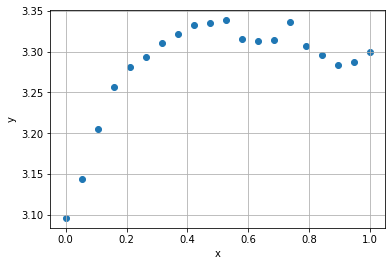

In [12]:
import numpy as np
import matplotlib.pyplot as plt
data = np.array([[0., 3.09621176],
        [0.05263158, 3.1439874 ],
        [0.10526316, 3.20488064],
        [0.15789474, 3.25677788],
        [0.21052632, 3.28074662],
        [0.26315789, 3.29389597],
        [0.31578947, 3.31029492],
        [0.36842105, 3.32189618],
        [0.42105263, 3.33234714],
        [0.47368421, 3.33545394],
        [0.52631579, 3.33849267],
        [0.57894737, 3.31554205],
        [0.63157895, 3.31275422],
        [0.68421053, 3.31412129],
        [0.73684211, 3.33618809],
        [0.78947368, 3.30658756],
        [0.84210526, 3.29551117],
        [0.89473684, 3.28314684],
        [0.94736842, 3.28691712],
        [1., 3.29905823]])
plt.scatter(data[:,0], data[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.grid('on')
plt.show()

We provide here some starting code, please complete the code using your knowledge of Pytorch.

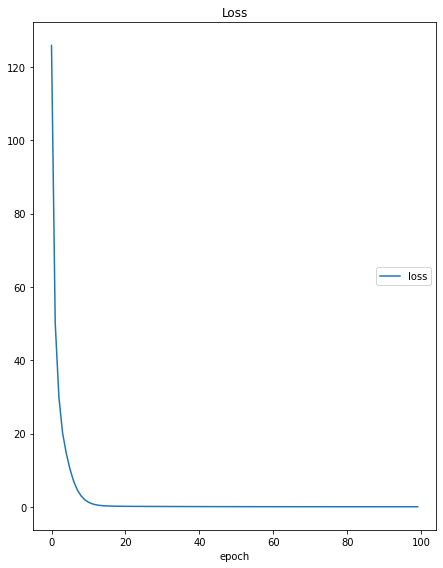

Loss
	loss             	 (min:    0.025, max:  125.878, cur:    0.025)
-0.1584300845861435 -0.28369683027267456 0.5562759041786194 3.1256771087646484


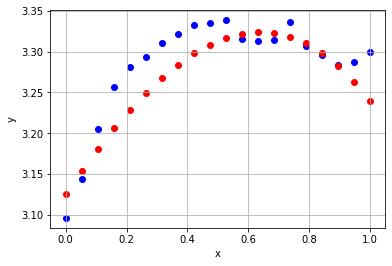

In [24]:
# Let's define the model function requested.
def f(w_1, w_2, w_3, b, x):
  return w_1 * x ** 3 + w_2 * x ** 2 + w_3 * x + b

# Let's define the loss function requested.
def L(w_1, w_2, w_3, b, y, ypred):
  return torch.sum((y - ypred).pow(2))

# Define the four parameters and start them with some random value.
w_1 = torch.tensor(0.001, requires_grad = True)
w_2 = torch.tensor(0.001, requires_grad = True)
w_3 = torch.tensor(0.001, requires_grad = True)
b = torch.tensor(0.001, requires_grad = True)

# Train data as pytorch tensors.
xs = torch.tensor(data[:, 0])
ys = torch.tensor(data[:, 1])


# Now find optimal values for w_1, w_2, w_3, and b.
######################

# Your code goes here.
liveloss = PlotLosses()

epochs = 100
learning_rate = 4e-2
optimizer = torch.optim.AdamW([w_1, w_2, w_3, b], lr = learning_rate)
for e in range(epochs):
    c_loss = 0
    for x, y in zip(xs, ys):
        optimizer.zero_grad()
        ypred = f(w_1, w_2, w_3, b, x)
        loss = L(w_1, w_2, w_3, b, y, ypred)
        c_loss += loss.item()

        loss.backward()
        optimizer.step()
    liveloss.update({"loss": c_loss})
    liveloss.send()

#####################

print(w_1.item(), w_2.item(), w_3.item(), b.item())


# Plot some sample points using your function with the found parameters.
xx = torch.tensor(np.linspace(0, 1, num=20))
yy = f(w_1, w_2, w_3, b, xx)
# Plot the original data in blue.
plt.scatter(data[:,0], data[:,1], c = 'blue')
# Plot new points by sampling from your function f(w1, w2, w3, b)
plt.scatter(xx.detach().numpy(), yy.detach().numpy(), c = 'red')
plt.xlabel('x')
plt.ylabel('y')
plt.grid('on')
plt.show()

#### **A.1 Train the Convolutional Neural Network in Section 3** [1pts]
Section 3 provides a simple convolutional neural network for you but does not show how to train it. Use the space below to write code to train the neural network. Feel free to re-use code from sections 2 and 3 of this assignment which are provided for you. The most important part is setting up the data appropriately and choosing the right variables such as learning rate, epochs, batch size, optimizer choices, etc. See the sample output below -- it is expected that you achieve about the same validation accuracy to obtain full points on this part. **Note:** Keep in mind that for you to score points your output needs to be on the notebook -- only providing code doesn't earn any points.

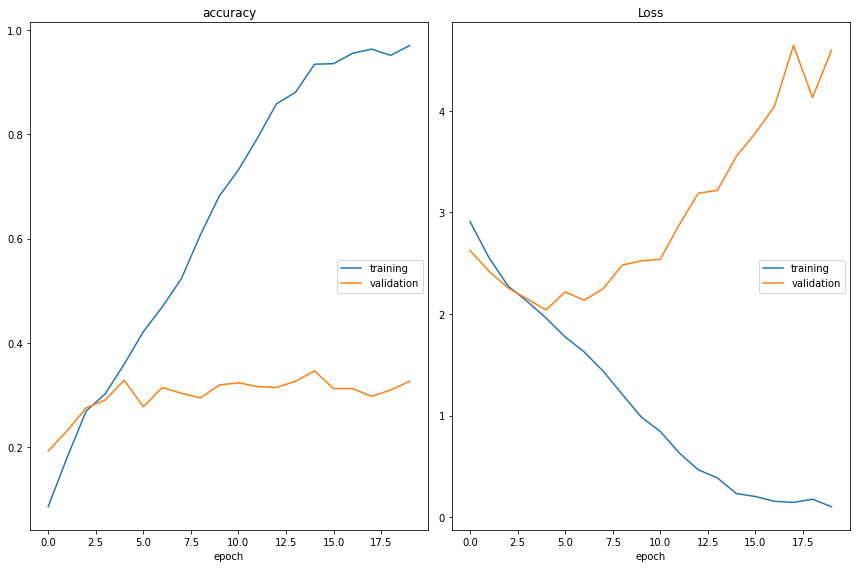

accuracy
	training         	 (min:    0.085, max:    0.971, cur:    0.971)
	validation       	 (min:    0.192, max:    0.346, cur:    0.326)
Loss
	training         	 (min:    0.104, max:    2.910, cur:    0.104)
	validation       	 (min:    2.041, max:    4.643, cur:    4.595)


In [46]:
# Your code goes here.

import torch.optim 
import torchvision.transforms as transforms

batch_size = 16
n_epochs = 20
learningRate = 1e-3

# torch.nn.CrossEntropyLoss applies the softmax to the predictions by the model.
cost_function = torch.nn.CrossEntropyLoss()
model = ConvnetClassifier()

# Basic SGD Optimizer.
optimizer = torch.optim.AdamW(model.parameters(), lr = learningRate)

transform = transforms.Compose([transforms.Resize((48, 48)),
                                transforms.ToTensor()])

trainset = SUN20(split = 'train', transform = transform)
valset = SUN20(split = 'val', transform = transform)

train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 2)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)

train_model(batch_size, n_epochs, learningRate, 
            model, cost_function, optimizer, -1, 
            train_loader, val_loader)

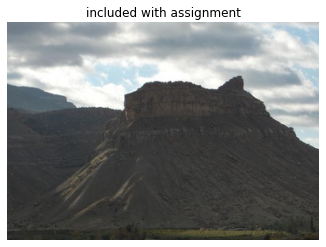

P("/a/arch") = 0.00
P("/b/bathroom") = 0.00
P("/b/butte") = 0.01
P("/d/dentists_office") = 0.00
P("/h/hot_spring") = 0.00
P("/j/jacuzzi/indoor") = 0.00
P("/l/laundromat") = 0.00
P("/l/lecture_room") = 0.00
P("/l/library/indoor") = 0.00
P("/l/lighthouse") = 0.00
P("/l/living_room") = 0.00
P("/m/mansion") = 0.00
P("/m/marsh") = 0.00
P("/m/mountain") = 0.85
P("/s/sauna") = 0.00
P("/s/shower") = 0.00
P("/s/skyscraper") = 0.00
P("/t/tower") = 0.00
P("/t/tree_house") = 0.04
P("/v/volcano") = 0.08


In [49]:
# Including an example prediction just for your reference to see the model is really working.

import matplotlib.pyplot as plt

input_image_id = 123

# Load the validation set in case not loaded.
valset = SUN20(split = 'val')

# Sample
x,y = valset[input_image_id]

# Process input and add a dummy batch dimension.
xp = transform(x)[None, :].to(device)

predictions = model(xp).softmax(dim = 1)

plt.figure();plt.title("included with assignment");plt.imshow(x);plt.axis(False);plt.show();

# Show predictions from this model.
for i in range(0, len(trainset.categories)):
  score = predictions[0, i].item()
  category = trainset.categories[i]
  print('P("{0}") = {1:.2f}'.format(category, score))


#### **A.2 Show results from the previously trained model** [1pts]
Show results for the model trained in the previous section (sec A.1) by displaying the top 20 images from the validation set that the model predicts as `butte`. Show the predicted scores for each somehow and put a green box around the images that are indeed a `butte` and a red box around the images whose true label is not `butte` as shown below. I used the Pillow's library ImageDraw class to draw a rectangle and draw some text on the images.

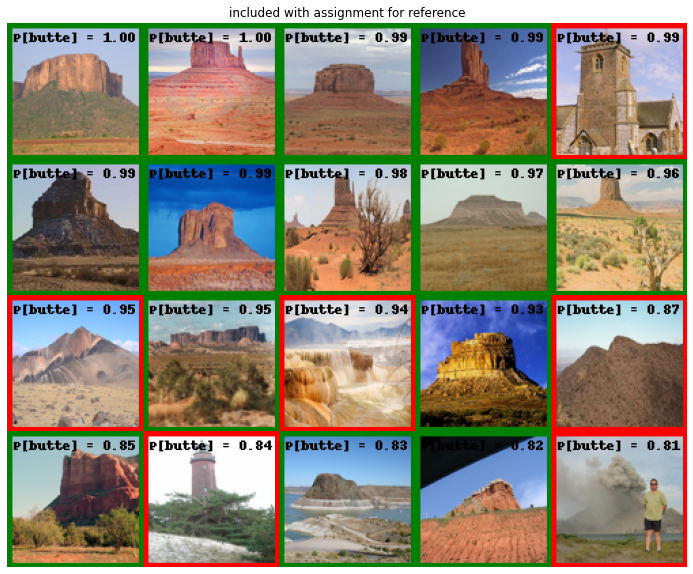

In [ ]:
# Your code goes here.

#### **A.3 Define and train a better Convolutional Neural Network** [2pts]
In section 3 and A.1 we defined and trained a Convnet, however we were only able to reach somewhat above 30% in accuracy. We should be able to do better with a Convnet if we add perhaps more layers, or batch normalization layers, or add some forms of regularization such as dropout layers, data augmentation, or choose optimization parameters more carefully -- or consider processing the images at a higher resolution than 48x48. Design and train a CNN that obtains at least 52% accuracy. This is number is slightly lower than the average accuracy that students obtained in a previous version of this class. The very best submissions obtained 60% accuracy or more, one obtained 58% with a training time under 5 minutes. My solution below was not in the top 10. To get full points in this question the network has to perform on par as what is shown here. Additionally, you have to enter the following information: Number of parameters of your network, training time of your network, and the maximum validation accuracy achieved [here](https://docs.google.com/spreadsheets/d/1Kr65G5Og1CNHXIOlnN3Xnf3WepocEhv5ND74fSYOaAg/edit?usp=sharing)

In [91]:
import torchvision, torch

class SceneClassifier(torch.nn.Module):
    def __init__(self):
        super(SceneClassifier, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = (3, 3), padding = 2)
        self.bn1 = torch.nn.BatchNorm2d(64)
        
        self.conv2 = torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3), padding = 2)
        self.bn2 = torch.nn.BatchNorm2d(128)
        
        self.conv3 = torch.nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3, 3), padding = 2)
        self.bn3 = torch.nn.BatchNorm2d(256)
        
        self.conv4 = torch.nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = (3, 3), padding = 2)
        self.bn4 = torch.nn.BatchNorm2d(512)

        self.conv5 = torch.nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = (3, 3), padding = 2)
        self.bn5 = torch.nn.BatchNorm2d(1024)
        # self.conv5 = torch.nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = (3, 3), padding = 2)
        self.linear1 = torch.nn.Linear(in_features = 1024 * 4 * 4, out_features = 512)
        # self.linear2 = torch.nn.Linear(in_features = 512, out_features = 256)
        self.linear2 = torch.nn.Linear(in_features = 512, out_features = 20)

    def forward(self, x):
        # First conv layer + maxpool2d + relu.
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        x = torch.nn.functional.relu(x)

        # Second conv layer + maxpool2d + relu.
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        x = torch.nn.functional.relu(x)

        # Second conv layer + maxpool2d + relu.
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        x = torch.nn.functional.relu(x)
        
        # Second conv layer + maxpool2d + relu.
        x = self.conv4(x)
        x = self.bn4(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        x = torch.nn.functional.relu(x)

        # Second conv layer + maxpool2d + relu.
        x = self.conv5(x)
        x = self.bn5(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        x = torch.nn.functional.relu(x)
        # Second conv layer + maxpool2d + relu.
        # x = self.conv5(x)
        # x = torch.nn.functional.max_pool2d(x, (2, 2))
        # x = torch.nn.functional.relu(x)

        # Vectorize except along the batch dimension.
        # You can always print here x.shape to see what it looks like.
        # print(x.shape)
        x = x.view(x.size(0), -1)
        # print(x.shape)
        # Pass through linear layers.
        x = self.linear1(x)
        x = torch.nn.functional.relu(x)
        x = self.linear2(x)
        # x = torch.nn.functional.relu(x)
        # x = self.linear3(x)
        
        return x

# Test your model!
# Create dummy batch with 24 samples, where each is an image of size 3x48x48.
model = SceneClassifier()
dummy_batch = torch.zeros(24, 3, 96, 96)
predictions = model(dummy_batch)

## This is how you can count the number of parameters
## in a neural network in pytorch in a generic way.
#
count_params = 0
for param in model.parameters():
 count_params += param.numel()
print(count_params)

14673940


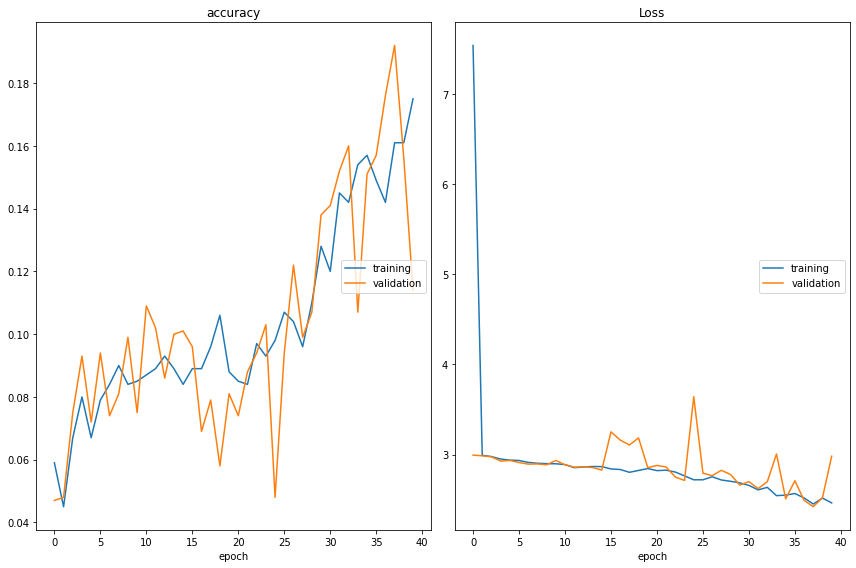

accuracy
	training         	 (min:    0.045, max:    0.175, cur:    0.175)
	validation       	 (min:    0.047, max:    0.192, cur:    0.114)
Loss
	training         	 (min:    2.453, max:    7.536, cur:    2.465)
	validation       	 (min:    2.423, max:    3.642, cur:    2.983)


In [95]:
# Your code goes here.

# Your code goes here.

import torch.optim 
import torchvision.transforms as transforms

batch_size = 16
n_epochs = 40
learningRate = 3e-3

# torch.nn.CrossEntropyLoss applies the softmax to the predictions by the model.
cost_function = torch.nn.CrossEntropyLoss()
model = SceneClassifier()

# Basic SGD Optimizer.
optimizer = torch.optim.AdamW(model.parameters(), lr = learningRate)

transform = transforms.Compose([transforms.RandomCrop((96, 96)),
                                # transforms.RandomHorizontalFlip(p=0.5),
                                # transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 5)),
                                # transforms.RandAugment(),
                                transforms.ToTensor()])

trainset = SUN20(split = 'train', transform = transform)
valset = SUN20(split = 'val', transform = transform)

train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 2)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)

train_model(batch_size, n_epochs, learningRate, 
            model, cost_function, optimizer, -1, 
            train_loader, val_loader)

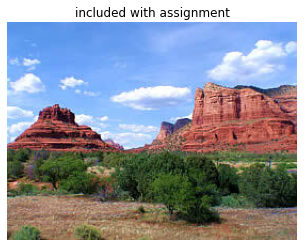

P("/a/arch") = 0.00
P("/b/bathroom") = 0.00
P("/b/butte") = 0.99
P("/d/dentists_office") = 0.00
P("/h/hot_spring") = 0.00
P("/j/jacuzzi/indoor") = 0.00
P("/l/laundromat") = 0.00
P("/l/lecture_room") = 0.00
P("/l/library/indoor") = 0.00
P("/l/lighthouse") = 0.00
P("/l/living_room") = 0.00
P("/m/mansion") = 0.00
P("/m/marsh") = 0.00
P("/m/mountain") = 0.01
P("/s/sauna") = 0.00
P("/s/shower") = 0.00
P("/s/skyscraper") = 0.00
P("/t/tower") = 0.00
P("/t/tree_house") = 0.00
P("/v/volcano") = 0.00


In [ ]:
# This is included here just for your reference.

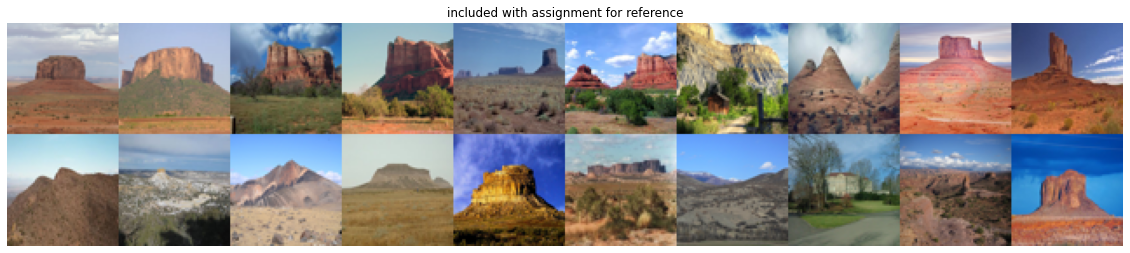

In [ ]:
# Showing here the images in the validation set with the largest predicted scores for /b/butte

#### **A.4 Finetuning an existing neural network from Pytorch's model library** [2pts]
Pytorch contains a rich library of pretrained models -- models that have already been trained over a really large scale dataset, often with millions of images and thousands of categories. Re-use one of these models with its pretrained weights and "finetune" it to perform well on the SUN20 dataset by replacing the last layer with a layer that predicts 20 outputs and run a couple of rounds of finetuning until you achieve a classifier that performs at about 90% accuracy -- ideally more. I used EfficientNet V2 Medium Size to obtain the performance below at 91.8% in just 7 epochs. Please enter the information for your implementation here: [spreadsheet](https://docs.google.com/spreadsheets/d/1xsZ4IuDjTulwg_0Q_zv59oqz7YFQcSGN_bK0PoroCQE/edit?usp=sharing)

In [ ]:
# Include here any necessary code to define and setup your model.

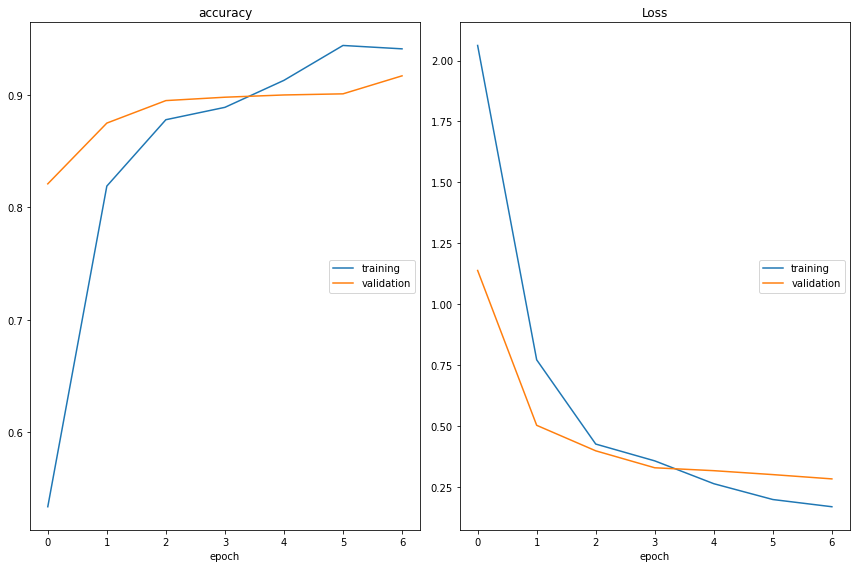

accuracy
	training         	 (min:    0.534, max:    0.944, cur:    0.941)
	validation       	 (min:    0.821, max:    0.917, cur:    0.917)
Loss
	training         	 (min:    0.168, max:    2.062, cur:    0.168)
	validation       	 (min:    0.283, max:    1.138, cur:    0.283)

 :: Sample output included with assignment for reference ::


In [ ]:
# Your training code goes here.

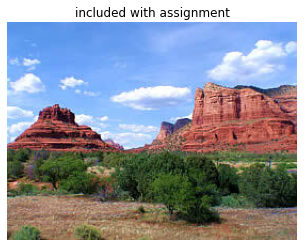

P("/a/arch") = 0.00
P("/b/bathroom") = 0.00
P("/b/butte") = 1.00
P("/d/dentists_office") = 0.00
P("/h/hot_spring") = 0.00
P("/j/jacuzzi/indoor") = 0.00
P("/l/laundromat") = 0.00
P("/l/lecture_room") = 0.00
P("/l/library/indoor") = 0.00
P("/l/lighthouse") = 0.00
P("/l/living_room") = 0.00
P("/m/mansion") = 0.00
P("/m/marsh") = 0.00
P("/m/mountain") = 0.00
P("/s/sauna") = 0.00
P("/s/shower") = 0.00
P("/s/skyscraper") = 0.00
P("/t/tower") = 0.00
P("/t/tree_house") = 0.00
P("/v/volcano") = 0.00


In [ ]:
# Optional: Test your model to see some predictions on some actual images.